In [2]:
## Install packages 

library(bigrquery)
library(ggplot2)
library(lubridate)
library(tidyverse)
install.packages("marginaleffects")
library(marginaleffects)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘insight’




In [69]:
## Load the data 

project_id="yhcr-prd-phm-bia-core"
attendance_sql <- "SELECT * FROM `yhcr-prd-phm-bia-core.CB_CLASS_ACT.attendance`"
attendance_table <- bq_project_query(project_id, attendance_sql)

In [70]:
## Specify experimental vs. controls 

start_date <- as.Date("2021-09-01")
end_date <- as.Date("2022-04-01")
hepa_school_codes <- c("H01", "H02", "H03", "H04", "H05", "H06", "H07", "H08",
"H09", "H10", "H11")
control_school_codes <- c("C01", "C02", "C03", "C04", "C05", "C09", "C10",
"C11", "C12", "C13", "C14")
study_schools <- c(hepa_school_codes, control_school_codes)


In [71]:
# download CO2 stats and format variables
co2_sql <- "SELECT School_ID, week_start, co2_mean FROM `yhcr-prd-phm-bia-core.CB_CLASS_ACT.stats_week_school_21_09_22`"
co2_table <- bq_project_query(project_id, co2_sql)
co2 <- bq_table_download(co2_table) %>% 
    rename(WeekStart = week_start, School_AnonID = School_ID) 

In [72]:
# download PM stats and format variables
pm_sql <- "SELECT School_ID, week_start, PM2_5_mean FROM `yhcr-prd-phm-bia-core.CB_CLASS_ACT.stats_week_school_21_09_22`"
pm_table <- bq_project_query(project_id, pm_sql)
pm <- bq_table_download(pm_table) %>% 
    rename(WeekStart = week_start, School_AnonID = School_ID) 

#head(pm)

In [73]:
# load in schools data for time-period of study - drop closures
attendance <- bq_table_download(attendance_table) %>%
    filter(School_AnonID %in% study_schools) %>% 
    filter(pct_in_school > 0) %>%
    filter(Unk / (pupils * 14) < 0.01) %>%
    filter(WeekStart < end_date) %>%
    mutate(arm = case_when(School_AnonID %in% hepa_school_codes ~ "HEPA", 
                           School_AnonID %in% control_school_codes ~ "Control"),
           mth = factor(month.abb[month(WeekStart)], 
                          levels=c("Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar"), 
                          ordered=TRUE),
           illness_rate = prop_absent_ill * 100) %>%
    group_by(WeekStart, arm) %>% 
    mutate(outlier_threshold = mean(prop_absent_ill) + 3.25*(IQR(prop_absent_ill, na.rm=TRUE)),
           is_outlier = prop_absent_ill > outlier_threshold) 


In [74]:
# download rate data from .gov site and format WeekStart and msoa varaiables
msoa_rates_link <- "https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&areaCode=E08000032&metric=newCasesBySpecimenDateRollingRate&format=csv"
msoa_rates_csv <- "msoa_2023-10-19.csv"
keep_cols <- c("msoa", "WeekStart", "covid_msoa_rate")
msoa_rates <- read_csv(msoa_rates_csv) %>%
    mutate(WeekStart = date - 5) %>%
    rename(covid_msoa_rate = newCasesBySpecimenDateRollingRate, 
           msoa = areaCode) %>%
    select(all_of(keep_cols)) 

Rows: 7876 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): regionCode, regionName, UtlaCode, UtlaName, LtlaCode, LtlaName, ar...
dbl  (1): newCasesBySpecimenDateRollingRate
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [75]:
#head(msoa_rates)

In [77]:
#attendance %>% filter(prop_absent_ill > 0.15)

In [78]:
colnames(attendance)

[1] "School_AnonID"     "WeekStart"         "pupils"           
 [4] "Unk"               "I02"               "X02"              
 [7] "X09"               "X06"               "X07"              
[10] "am"                "pm"                "closed"           
[13] "X08"               "X01"               "I01"              
[16] "B"                 "C"                 "D"                
[19] "E"                 "G"                 "H"                
[22] "I"                 "J"                 "L"                
[25] "M"                 "N"                 "O"                
[28] "P"                 "R"                 "S"                
[31] "T"                 "U"                 "V"                
[34] "W"                 "X"                 "Y"                
[37] "Z"                 "in_school"         "ill"              
[40] "pct_in_school"     "prop_absent_ill"   "msoa"             
[43] "arm"               "mth"               "illness_rate"     
[46] "outlier_threshold" "is_outlier"

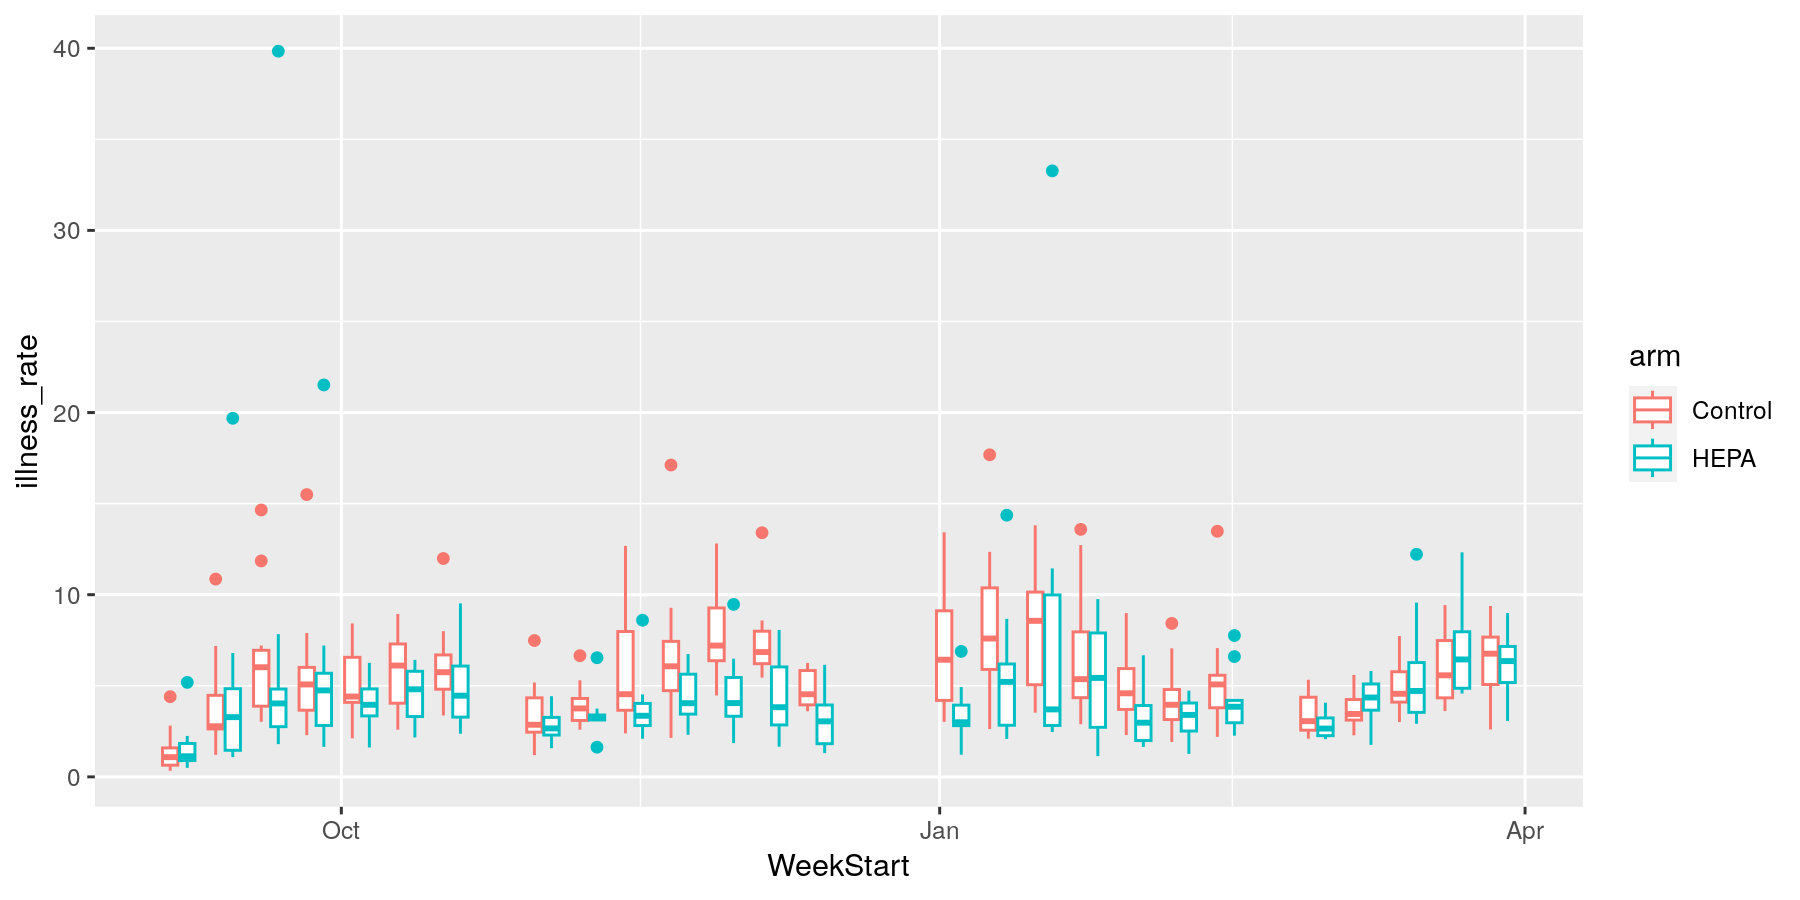

In [79]:

options(repr.plot.width = 9, repr.plot.height = 4.5, repr.plot.res = 200)
attendance %>% 
    ggplot() +
    geom_boxplot(aes(x=WeekStart, y=illness_rate, group=interaction(WeekStart, arm), color=arm)) 

In [80]:
attendance %>% 
    left_join(msoa_rates) %>%
    left_join(co2) %>%
    left_join(pm) %>% 
colnames()

df <- attendance %>% 
    left_join(msoa_rates) %>%
    left_join(co2) %>%
    left_join(pm) %>%
select(School_AnonID, msoa, arm, mth, illness_rate, covid_msoa_rate, co2_mean, PM2_5_mean)


Joining with `by = join_by(WeekStart, msoa)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Joining with `by = join_by(School_AnonID, WeekStart)`


[1] "School_AnonID"     "WeekStart"         "pupils"           
 [4] "Unk"               "I02"               "X02"              
 [7] "X09"               "X06"               "X07"              
[10] "am"                "pm"                "closed"           
[13] "X08"               "X01"               "I01"              
[16] "B"                 "C"                 "D"                
[19] "E"                 "G"                 "H"                
[22] "I"                 "J"                 "L"                
[25] "M"                 "N"                 "O"                
[28] "P"                 "R"                 "S"                
[31] "T"                 "U"                 "V"                
[34] "W"                 "X"                 "Y"                
[37] "Z"                 "in_school"         "ill"              
[40] "pct_in_school"     "prop_absent_ill"   "msoa"             
[43] "arm"               "mth"               "illness_rate"     
[46] "outlier_threshold" "is_outlier"        "covid_msoa_rate"  
[49] "co2_mean"          "PM2_5_mean"

Joining with `by = join_by(WeekStart, msoa)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Adding missing grouping variables: `WeekStart`


In [81]:
#df

## COVID RATES 

In [83]:
covid_lm <- stats::lm(covid_msoa_rate ~ arm, data = df)
summary(covid_lm)


Call:
stats::lm(formula = covid_msoa_rate ~ arm, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-446.46 -319.81 -177.66   93.39 2586.95 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   516.55      29.89  17.283   <2e-16 ***
armHEPA       -20.39      43.30  -0.471    0.638    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 498.3 on 529 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.0004192,	Adjusted R-squared:  -0.00147 
F-statistic: 0.2219 on 1 and 529 DF,  p-value: 0.6378


Joining with `by = join_by(WeekStart, msoa)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Joining with `by = join_by(School_AnonID, WeekStart)`
`summarise()` has grouped output by 'School_AnonID', 'mth', 'arm'. You can
override using the `.groups` argument.


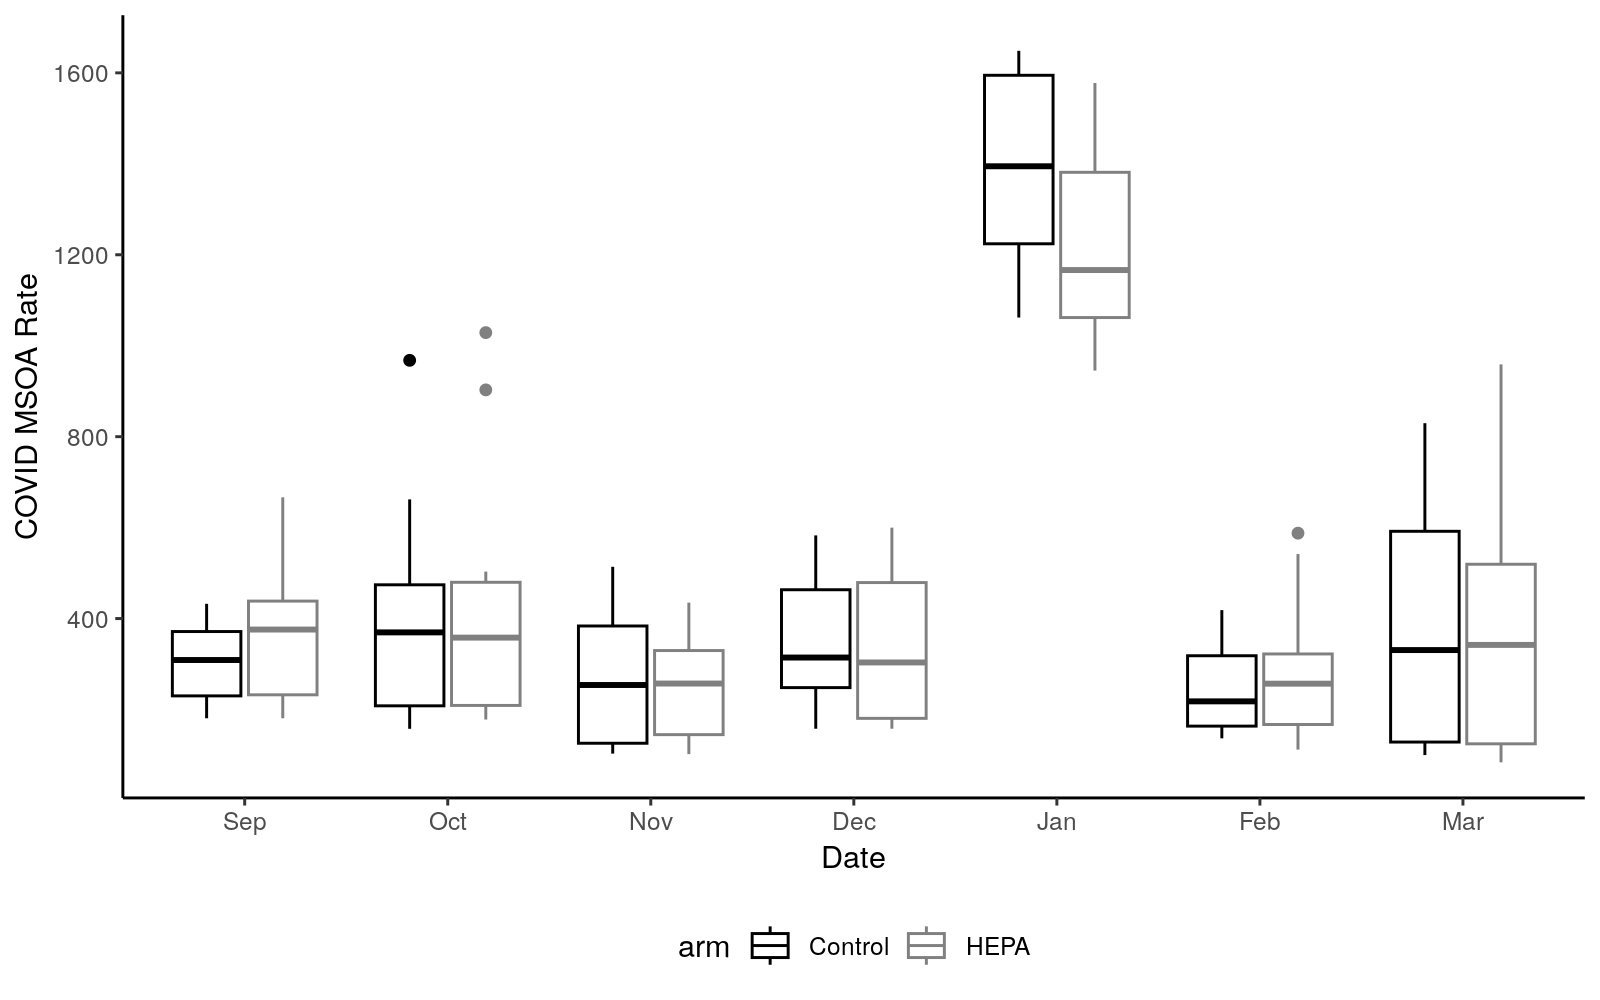

In [84]:

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
arm_colors <- c(HEPA = "#808080", Control = "#000000")
msoa_covid_p <- attendance %>% 
    left_join(msoa_rates) %>%
    left_join(co2) %>%
    left_join(pm) %>% 
    group_by(School_AnonID, mth, arm, msoa) %>% 
    summarise(total_in_school = sum(in_school),
              total_ill = sum(ill),
              overall_illness_rate = total_ill/total_in_school * 100,
              mean_weekly_illness_ratio = mean(prop_absent_ill),
              mean_msoa_rate = mean(covid_msoa_rate, na.rm=TRUE),
              mean_co2 = mean(co2_mean, na.rm=TRUE),
              mean_pm = mean(PM2_5_mean, na.rm = T)) %>%
    ungroup() %>%
    ggplot() +
    geom_boxplot(aes(x=mth, y=mean_msoa_rate, color=arm)) +
    xlab("Date") +
    ylab("COVID MSOA Rate") +
    theme_classic() +
    scale_color_manual(values=arm_colors, breaks=c("Control", "HEPA")) +
    theme(legend.direction = "horizontal", 
        legend.position = "bottom",
        legend.box = "horizontal"
    )
msoa_covid_p

## CO2 RATES 

In [85]:
co2_lm <- stats::lm(co2_mean ~ arm, data = df)
summary(co2_lm)


Call:
stats::lm(formula = co2_mean ~ arm, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-618.30 -209.31    7.06  196.55  892.78 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1213.86      17.95  67.632   <2e-16 ***
armHEPA        55.44      25.96   2.136   0.0332 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 283.2 on 475 degrees of freedom
  (56 observations deleted due to missingness)
Multiple R-squared:  0.009511,	Adjusted R-squared:  0.007426 
F-statistic: 4.561 on 1 and 475 DF,  p-value: 0.03321


Joining with `by = join_by(WeekStart, msoa)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Joining with `by = join_by(School_AnonID, WeekStart)`
`summarise()` has grouped output by 'School_AnonID', 'mth', 'arm'. You can
override using the `.groups` argument.
Warning message:
“Removed 1 rows containing non-finite values (`stat_boxplot()`).”


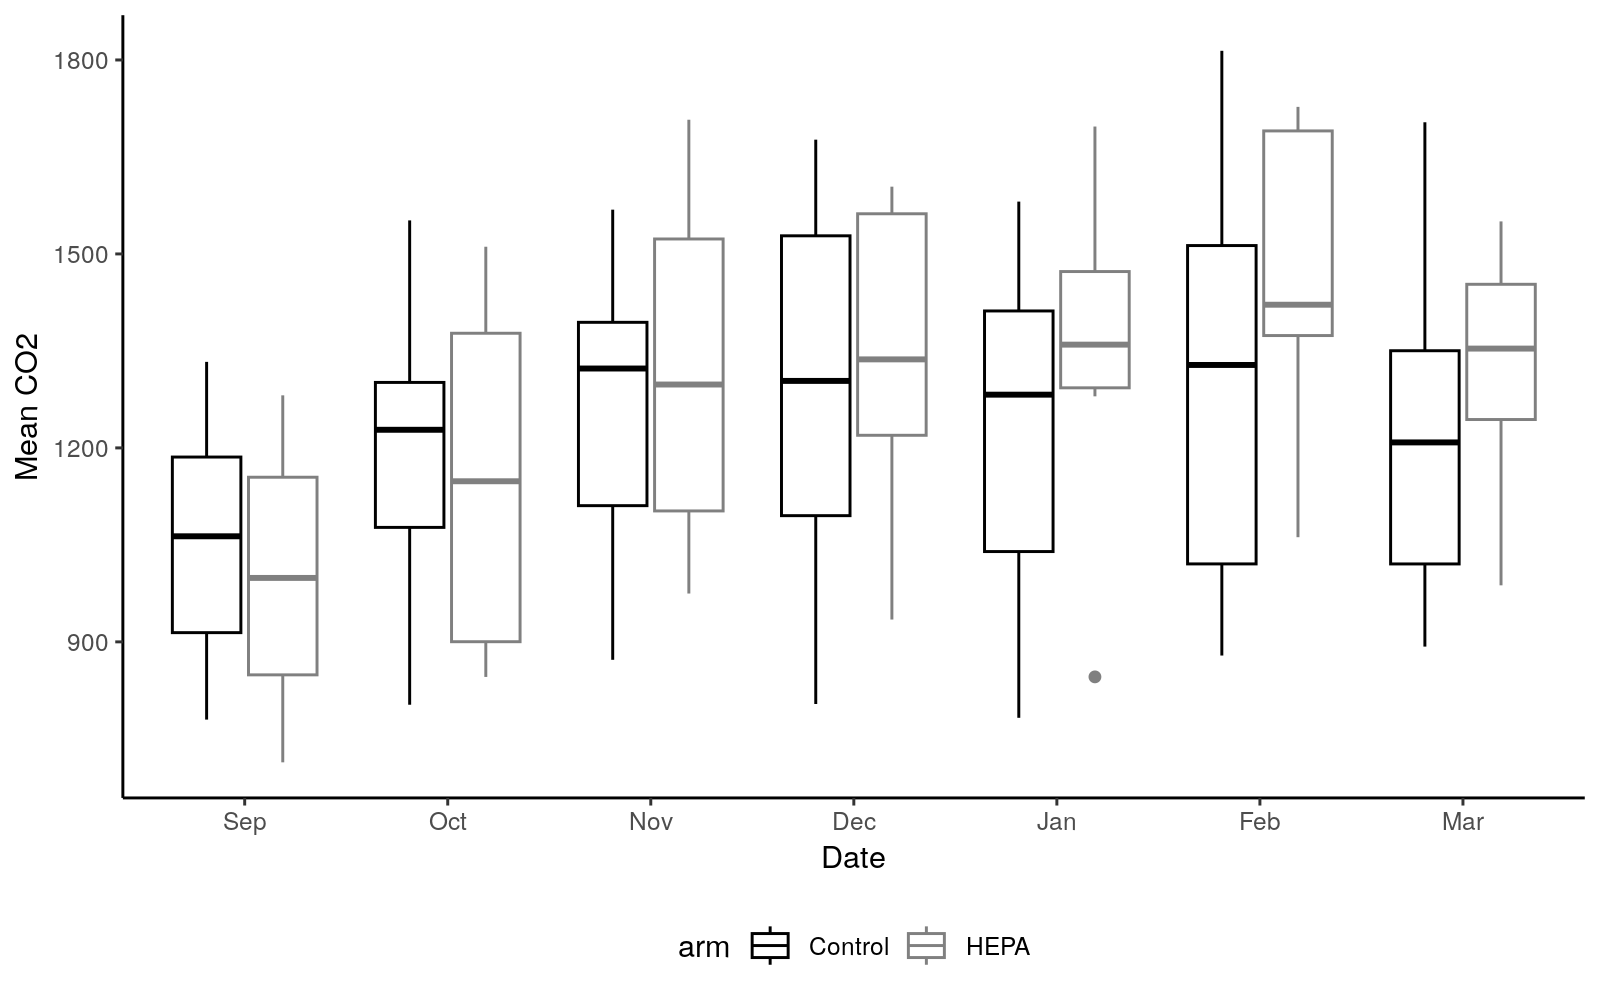

In [86]:

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
arm_colors <- c(HEPA = "#808080", Control = "#000000")
co2_p <- attendance %>% 
    left_join(msoa_rates) %>%
    left_join(co2) %>%
    left_join(pm) %>% 
    group_by(School_AnonID, mth, arm, msoa) %>% 
    summarise(total_in_school = sum(in_school),
              total_ill = sum(ill),
              overall_illness_rate = total_ill/total_in_school * 100,
              mean_weekly_illness_ratio = mean(prop_absent_ill),
              mean_msoa_rate = mean(covid_msoa_rate, na.rm=TRUE),
              mean_co2 = mean(co2_mean, na.rm=TRUE),
              mean_pm = mean(PM2_5_mean, na.rm = T)) %>%
    ungroup() %>%
    ggplot() +
    geom_boxplot(aes(x=mth, y=mean_co2, color=arm)) +
    xlab("Date") +
    ylab("Mean CO2") +
    theme_classic() +
    scale_color_manual(values=arm_colors, breaks=c("Control", "HEPA")) +
    theme(legend.direction = "horizontal", 
        legend.position = "bottom",
        legend.box = "horizontal"
    )
co2_p

## PM RATES

In [87]:
pm2_lm <- stats::lm(PM2_5_mean ~ arm, data = df)
summary(pm2_lm) 


Call:
stats::lm(formula = PM2_5_mean ~ arm, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-3.572 -1.996 -0.998 -0.330 57.246 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.7934     0.3010  15.925  < 2e-16 ***
armHEPA      -2.5844     0.4354  -5.936 5.64e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.75 on 475 degrees of freedom
  (56 observations deleted due to missingness)
Multiple R-squared:  0.06906,	Adjusted R-squared:  0.0671 
F-statistic: 35.24 on 1 and 475 DF,  p-value: 5.638e-09


Joining with `by = join_by(WeekStart, msoa)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Joining with `by = join_by(School_AnonID, WeekStart)`
`summarise()` has grouped output by 'School_AnonID', 'mth', 'arm'. You can
override using the `.groups` argument.
Warning message:
“Removed 40 rows containing non-finite values (`stat_boxplot()`).”


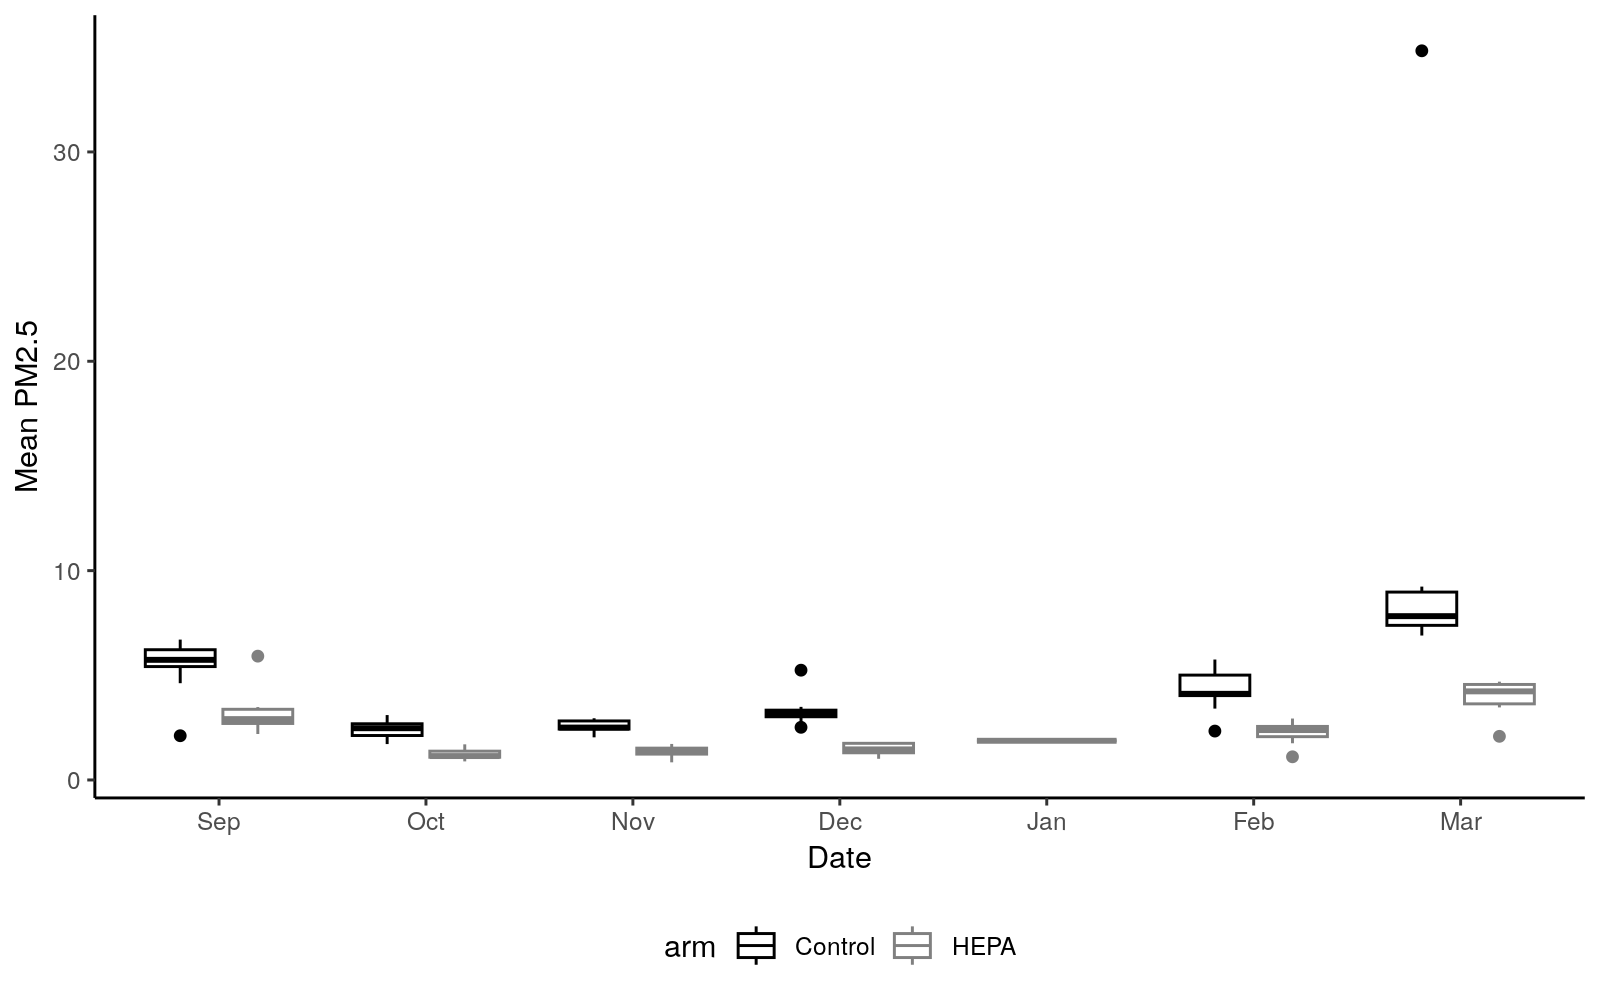

In [88]:

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200)
arm_colors <- c(HEPA = "#808080", Control = "#000000")
pm2_plot <- attendance %>% 
    left_join(msoa_rates) %>%
    left_join(co2) %>%
    left_join(pm) %>% 
    group_by(School_AnonID, mth, arm, msoa) %>% 
    summarise(total_in_school = sum(in_school),
              total_ill = sum(ill),
              overall_illness_rate = total_ill/total_in_school * 100,
              mean_weekly_illness_ratio = mean(prop_absent_ill),
              mean_msoa_rate = mean(covid_msoa_rate, na.rm=TRUE),
              mean_co2 = mean(co2_mean, na.rm=TRUE),
              mean_pm = mean(PM2_5_mean, na.rm = T)) %>%
    ungroup() %>%
    ggplot() +
    geom_boxplot(aes(x=mth, y=mean_pm, color=arm)) +
    xlab("Date") +
    ylab("Mean PM2.5") +
    theme_classic() +
    scale_color_manual(values=arm_colors, breaks=c("Control", "HEPA")) +
    theme(legend.direction = "horizontal", 
        legend.position = "bottom",
        legend.box = "horizontal"
    )
pm2_plot

### Above repeated with outliers removed 

In [89]:
df_wo_outliers <- attendance %>% 
    filter(!is_outlier) %>% 
    left_join(msoa_rates) %>%
    left_join(co2) %>%
    left_join(pm) %>%
select(School_AnonID, msoa, arm, mth, illness_rate, covid_msoa_rate, co2_mean, PM2_5_mean) 

Joining with `by = join_by(WeekStart, msoa)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Joining with `by = join_by(School_AnonID, WeekStart)`
Adding missing grouping variables: `WeekStart`


In [90]:
pm2_lm_outliers <- stats::lm(PM2_5_mean ~ arm, data = df_wo_outliers)
    summary(pm2_lm_outliers) 


Call:
stats::lm(formula = PM2_5_mean ~ arm, data = df_wo_outliers)

Residuals:
   Min     1Q Median     3Q    Max 
-3.621 -2.024 -1.005 -0.343 57.197 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.8428     0.3073  15.760  < 2e-16 ***
armHEPA      -2.6464     0.4457  -5.937 5.69e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.8 on 463 degrees of freedom
  (56 observations deleted due to missingness)
Multiple R-squared:  0.07075,	Adjusted R-squared:  0.06874 
F-statistic: 35.25 on 1 and 463 DF,  p-value: 5.689e-09


In [91]:
co2_lm_outliers <- stats::lm(co2_mean ~ arm, data = df_wo_outliers)
summary(co2_lm_outliers)


Call:
stats::lm(formula = co2_mean ~ arm, data = df_wo_outliers)

Residuals:
    Min      1Q  Median      3Q     Max 
-629.92 -208.75    8.46  195.76  890.14 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1216.51      17.91  67.912   <2e-16 ***
armHEPA        64.41      25.98   2.479   0.0135 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 279.8 on 463 degrees of freedom
  (56 observations deleted due to missingness)
Multiple R-squared:  0.0131,	Adjusted R-squared:  0.01097 
F-statistic: 6.145 on 1 and 463 DF,  p-value: 0.01353


In [92]:
covid_lm_outliers <- stats::lm(covid_msoa_rate ~ arm, data = df_wo_outliers)
summary(covid_lm_outliers)


Call:
stats::lm(formula = covid_msoa_rate ~ arm, data = df_wo_outliers)

Residuals:
    Min      1Q  Median      3Q     Max 
-446.51 -321.69 -179.51   92.46 2584.69 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   518.81      30.41  17.059   <2e-16 ***
armHEPA       -23.04      44.17  -0.522    0.602    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 502.5 on 517 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.0005261,	Adjusted R-squared:  -0.001407 
F-statistic: 0.2721 on 1 and 517 DF,  p-value: 0.6021


In [93]:
## Download agg data 

agg_data <- bq_table_download(attendance_table) %>%
filter(School_AnonID %in% study_schools) %>%
filter(pct_in_school > 0) %>%
filter(Unk / (pupils * 14) < 0.01) %>%
filter(WeekStart < end_date) %>%
mutate(arm = case_when(School_AnonID %in% hepa_school_codes ~ "HEPA",
School_AnonID %in% control_school_codes ~ "Control"),
mth = factor(month.abb[month(WeekStart)],
levels=c("Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar"),
ordered=TRUE),
illness_rate = prop_absent_ill * 100) %>%
group_by(WeekStart, arm) %>%
mutate(outlier_threshold = mean(prop_absent_ill) + 3.25 *(IQR(prop_absent_ill, na.rm=TRUE)),
is_outlier = prop_absent_ill > outlier_threshold) %>%
group_by(School_AnonID, arm) %>%
summarise(in_school = sum(in_school),
ill = sum(ill)) %>%
pivot_longer(cols=c(in_school, ill),
names_to = "attendance_type",
values_to = "attendance_count") %>%
mutate(is_illness = as.integer(attendance_type == "ill"),
hepa_filters = as.integer(arm == "HEPA"))

`summarise()` has grouped output by 'School_AnonID'. You can override using the
`.groups` argument.


In [94]:
#agg_data